In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P28DR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 24815 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'layer', 'cluster', 'Type', 'Subclass', 'Class_broad'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 4704 × 53801
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'layer', 'cluster', 'Type', 'Subclass', 'Class_broad'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

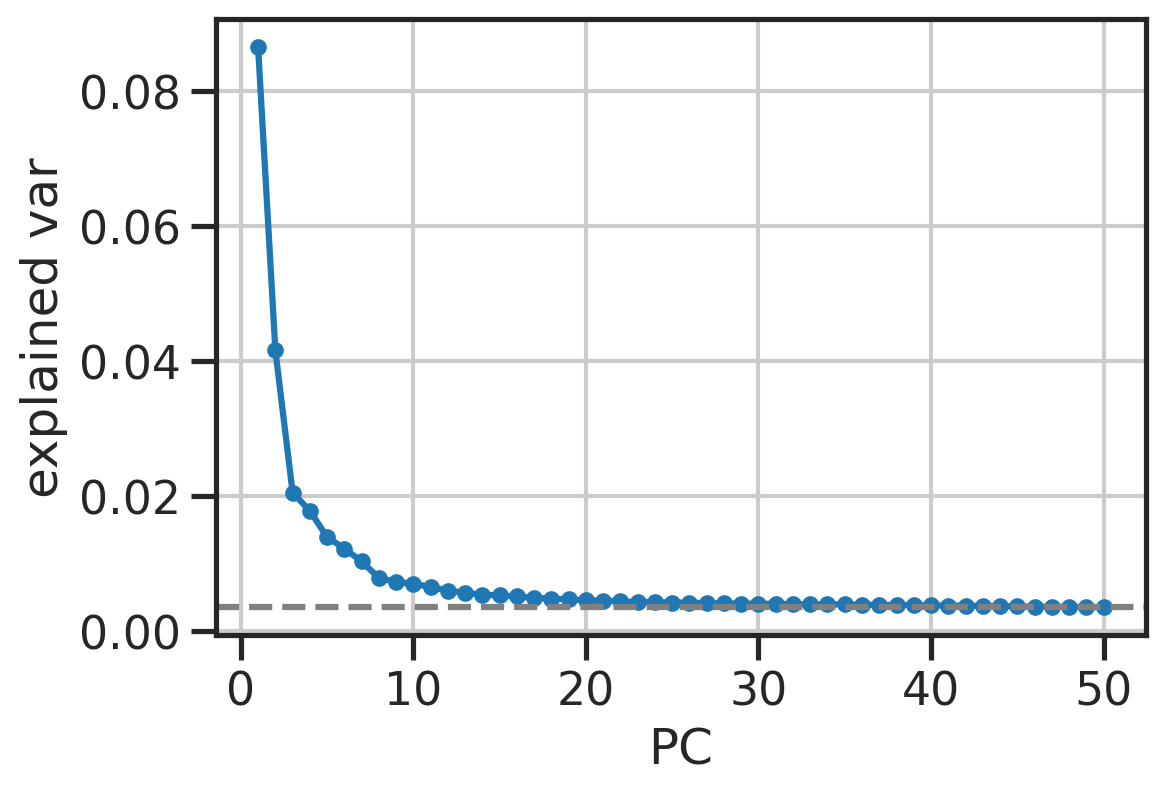

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

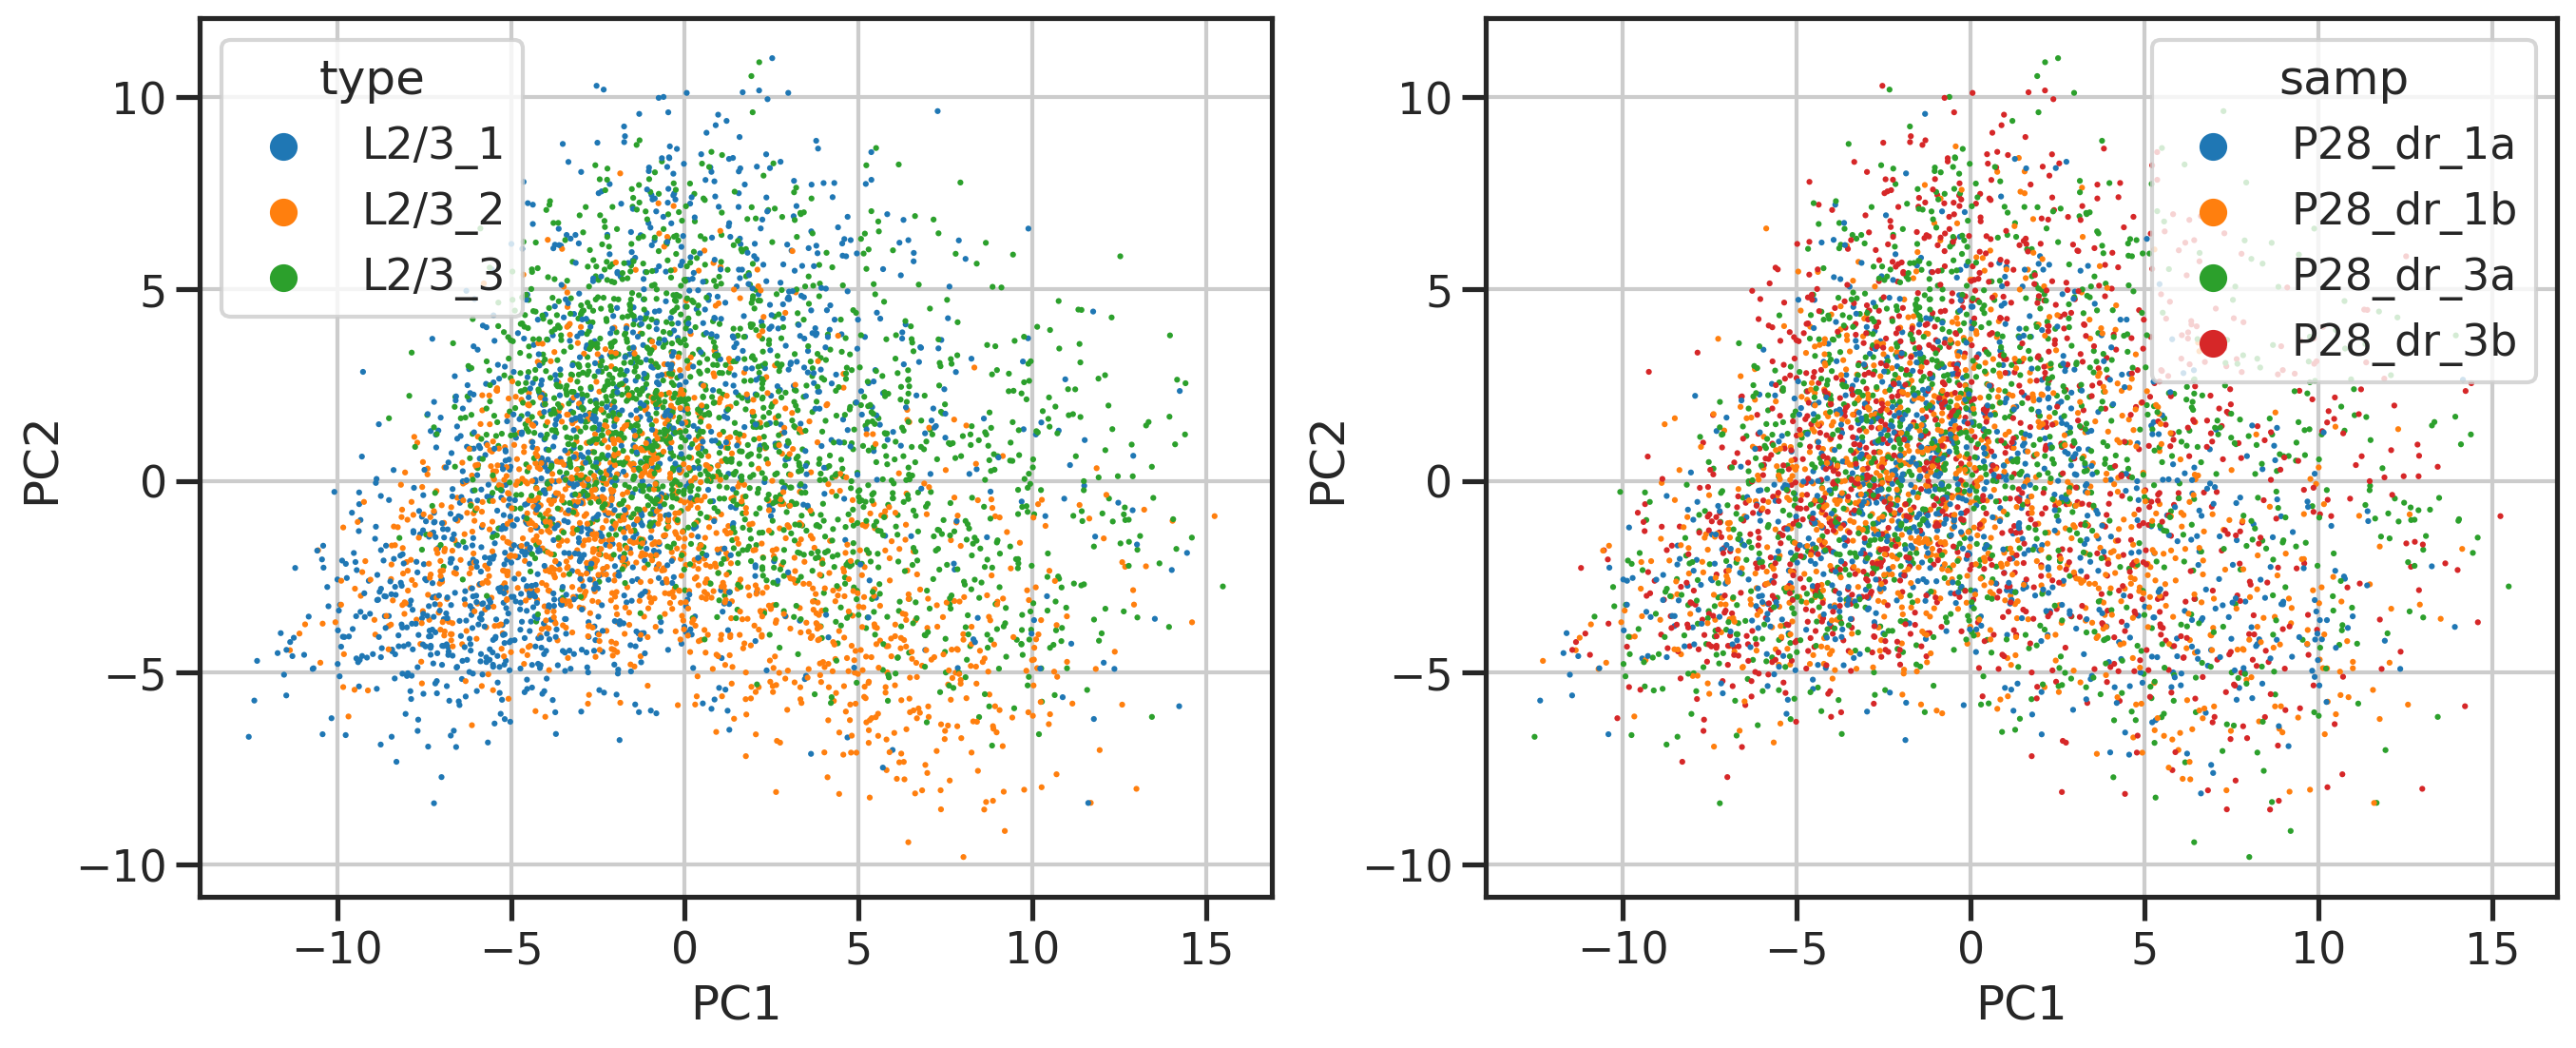

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

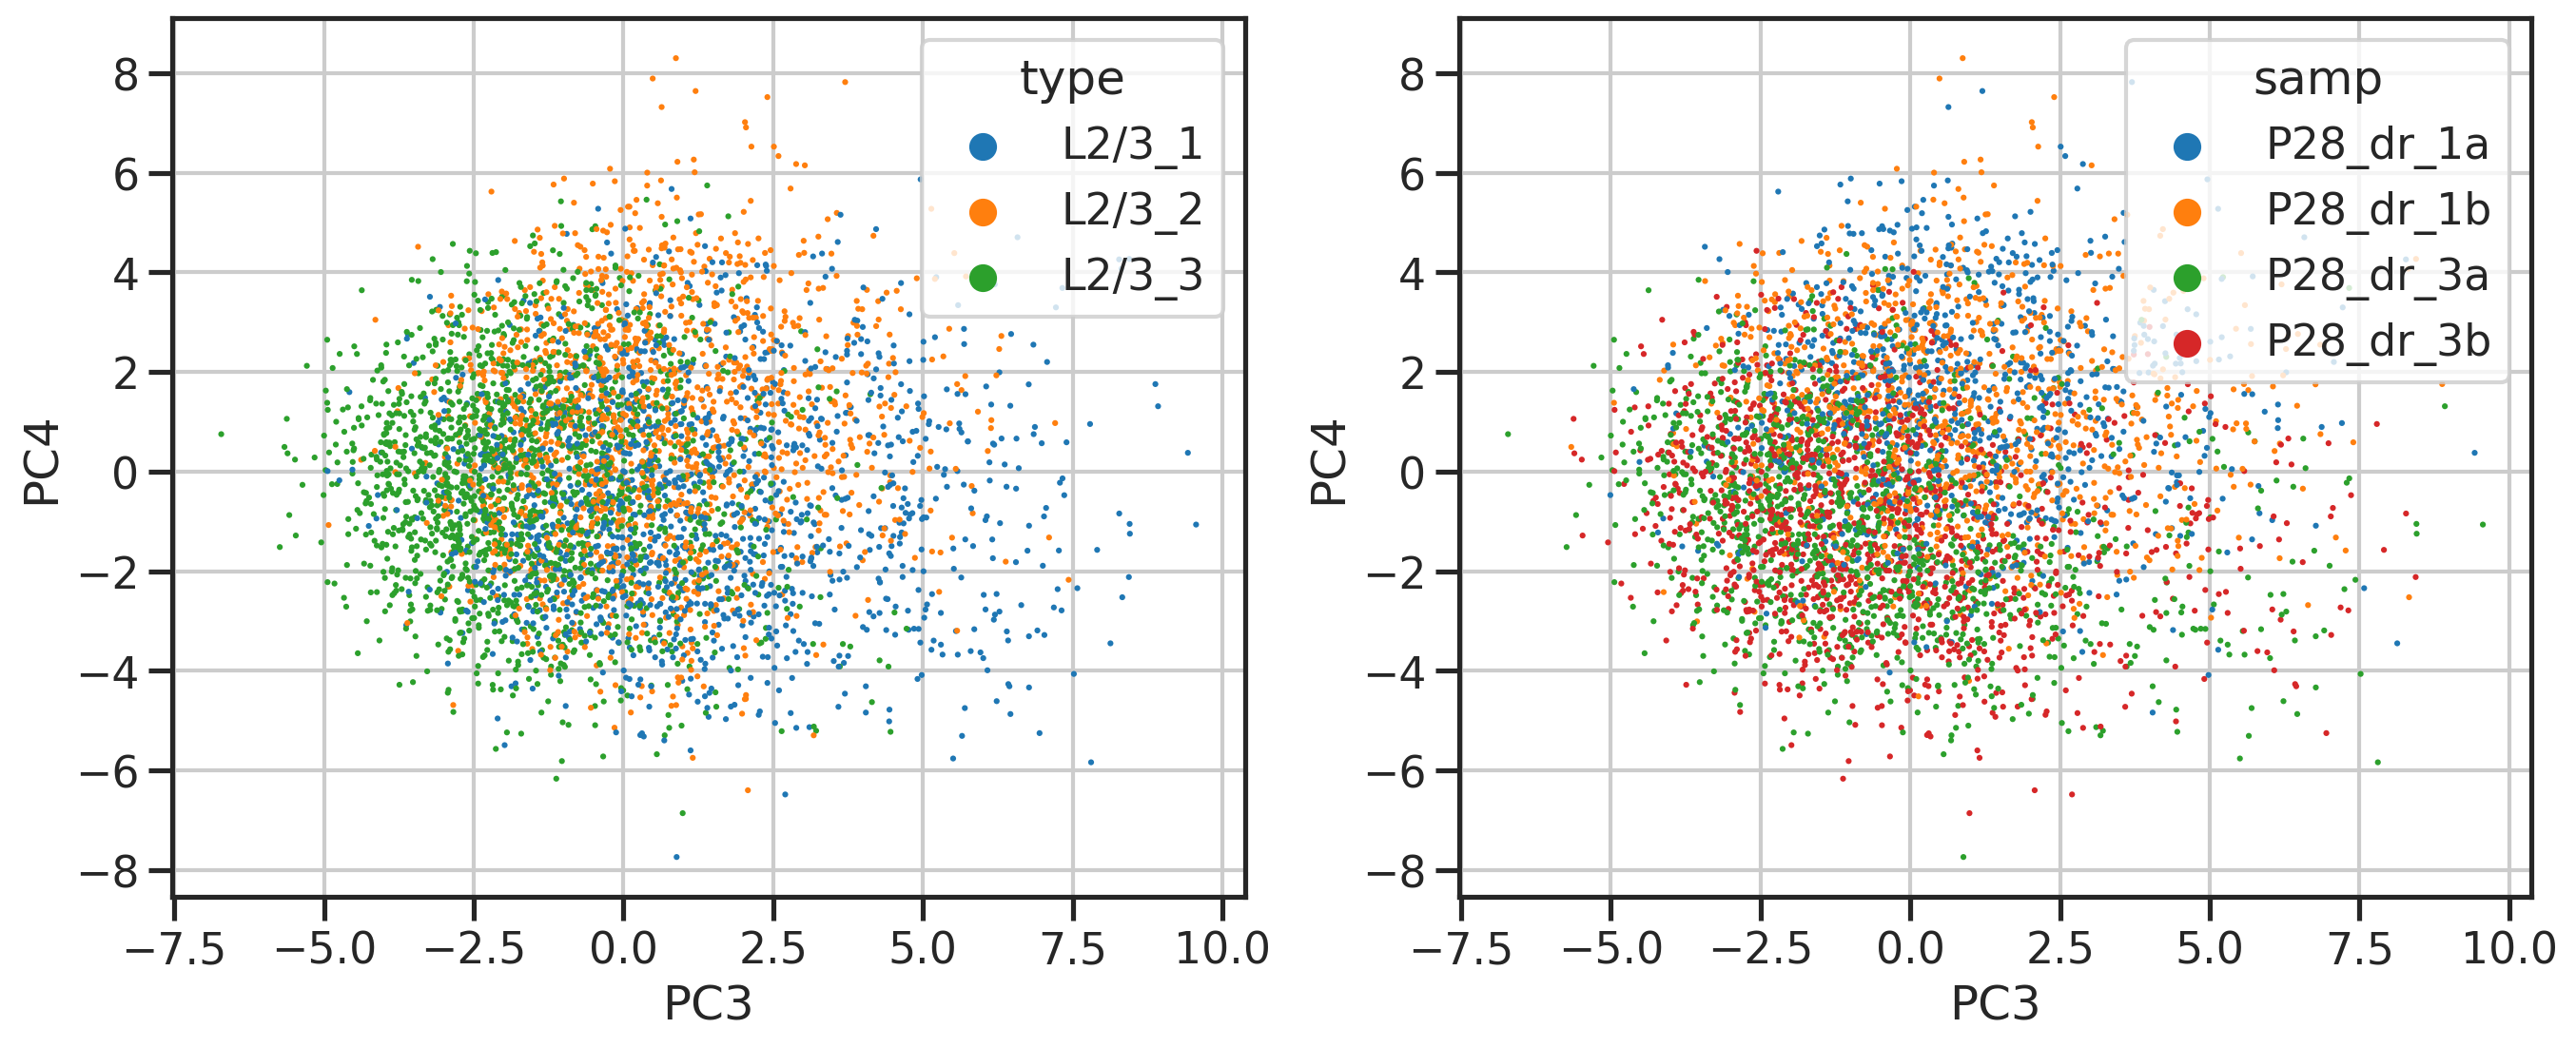

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

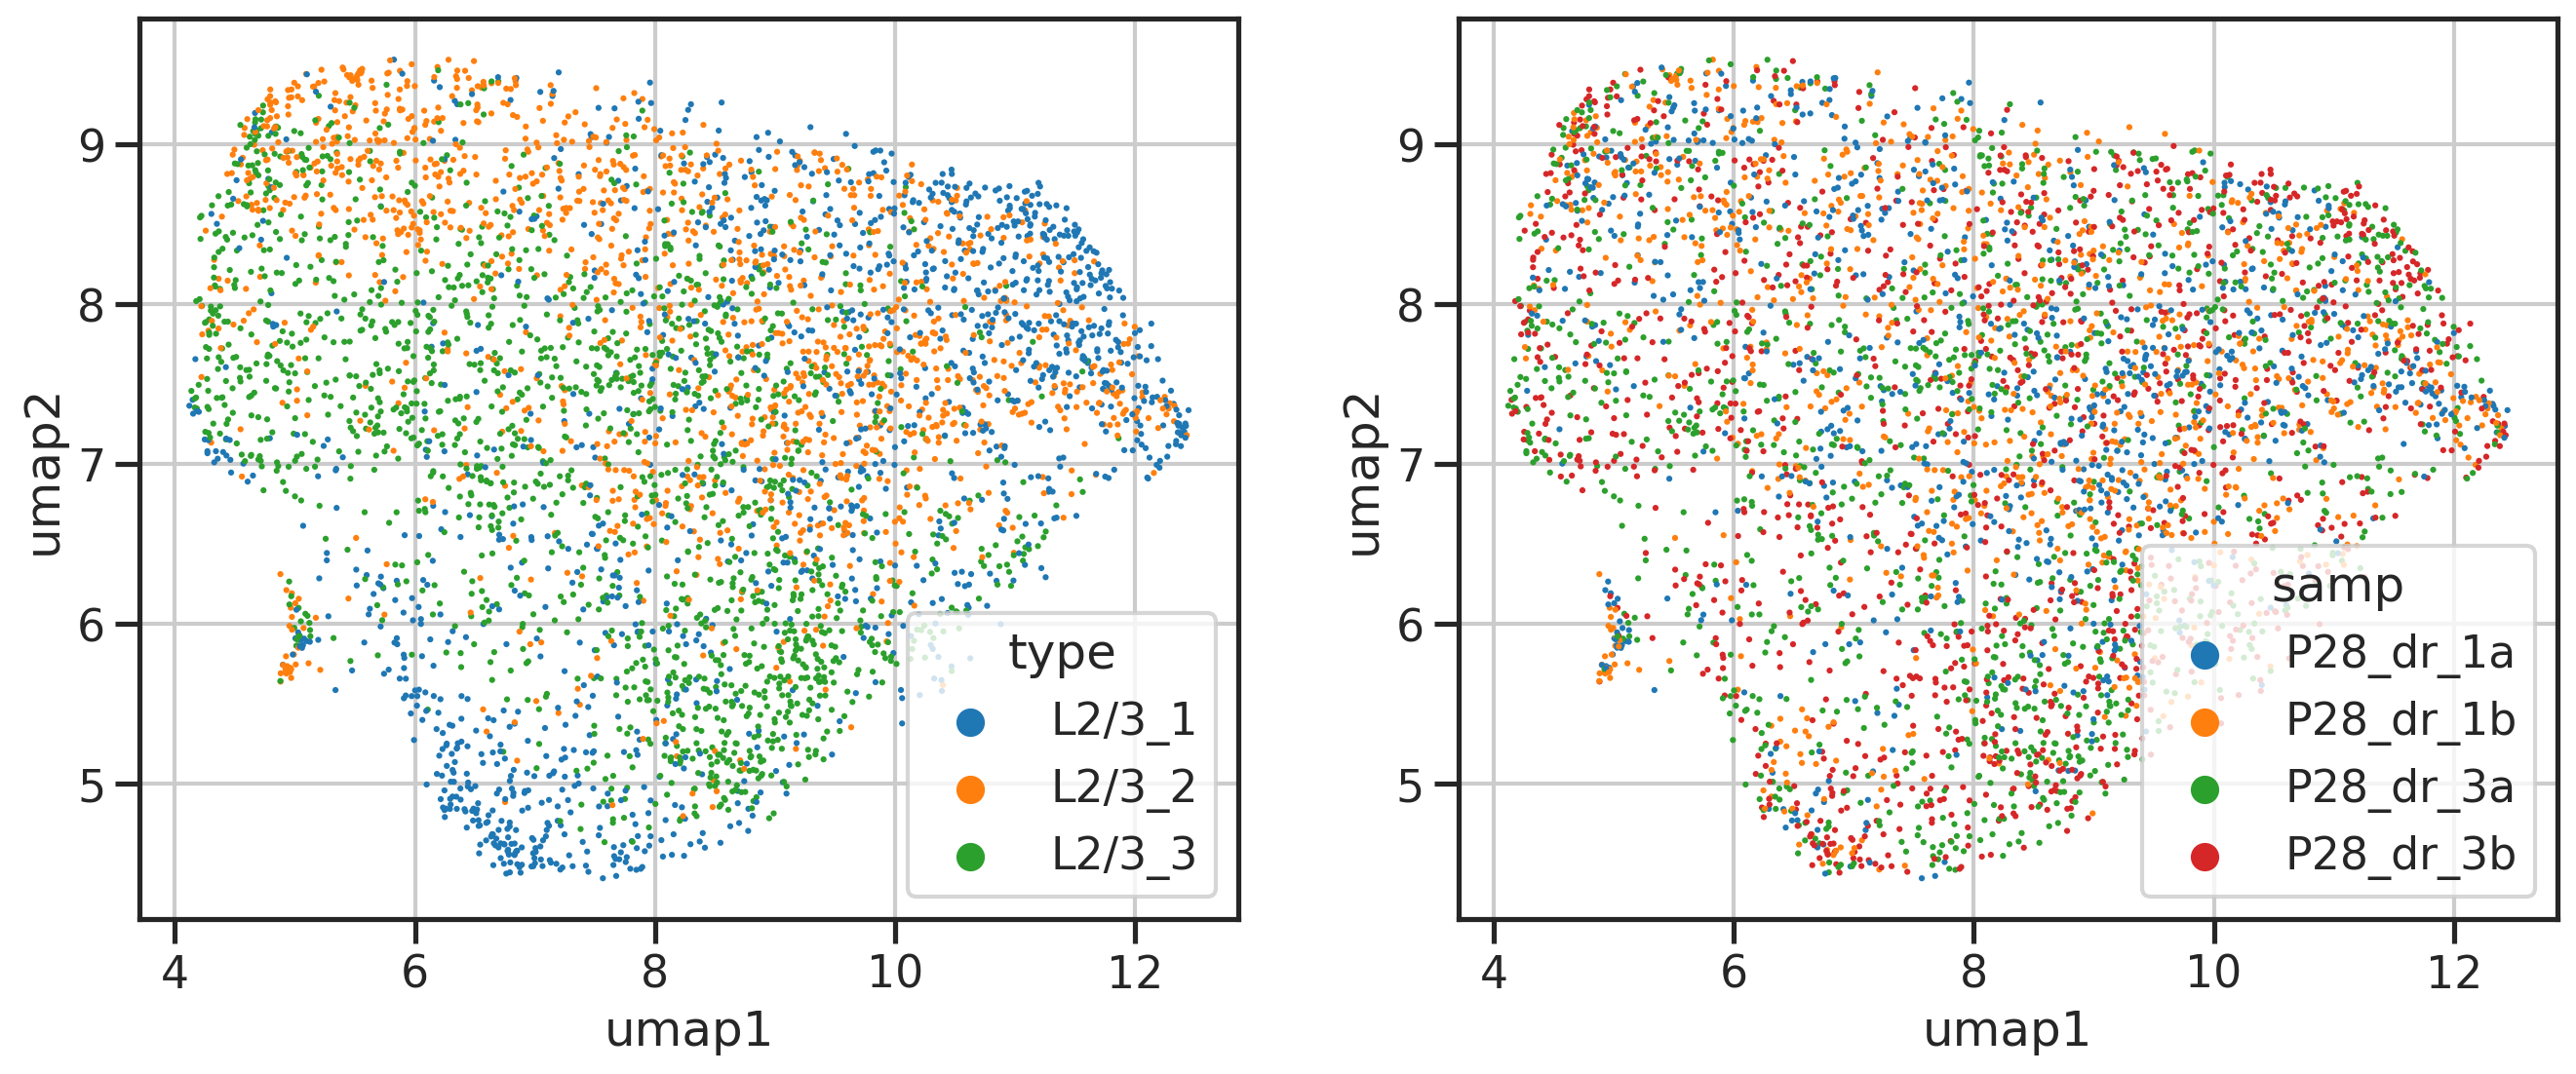

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

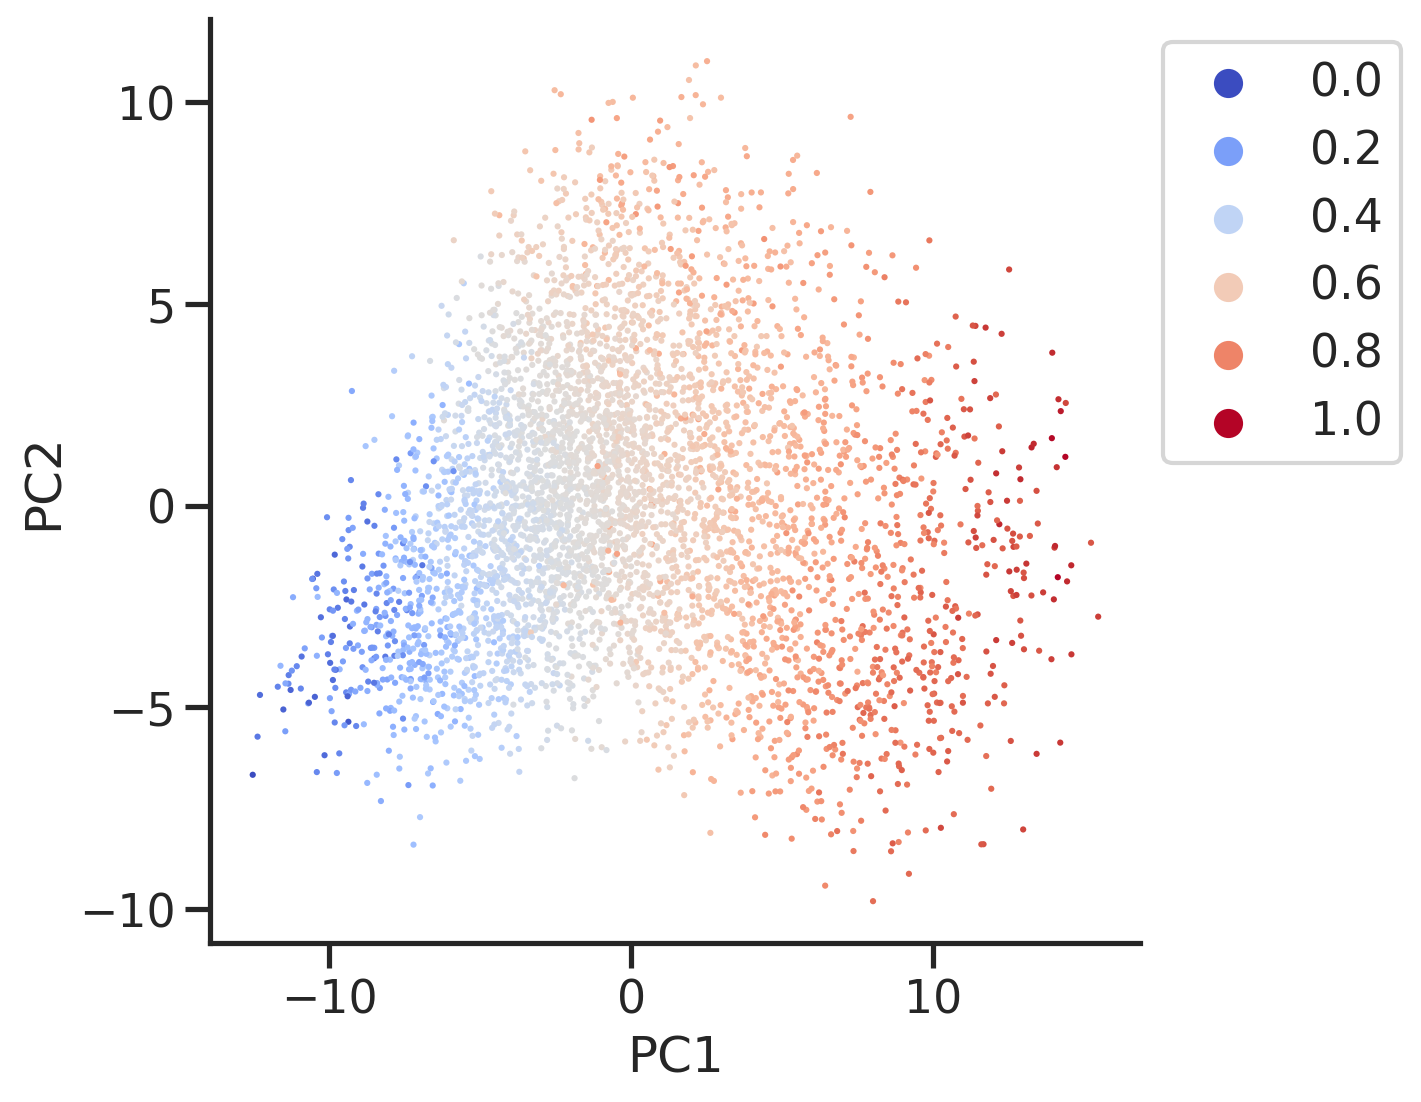

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:06:49 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


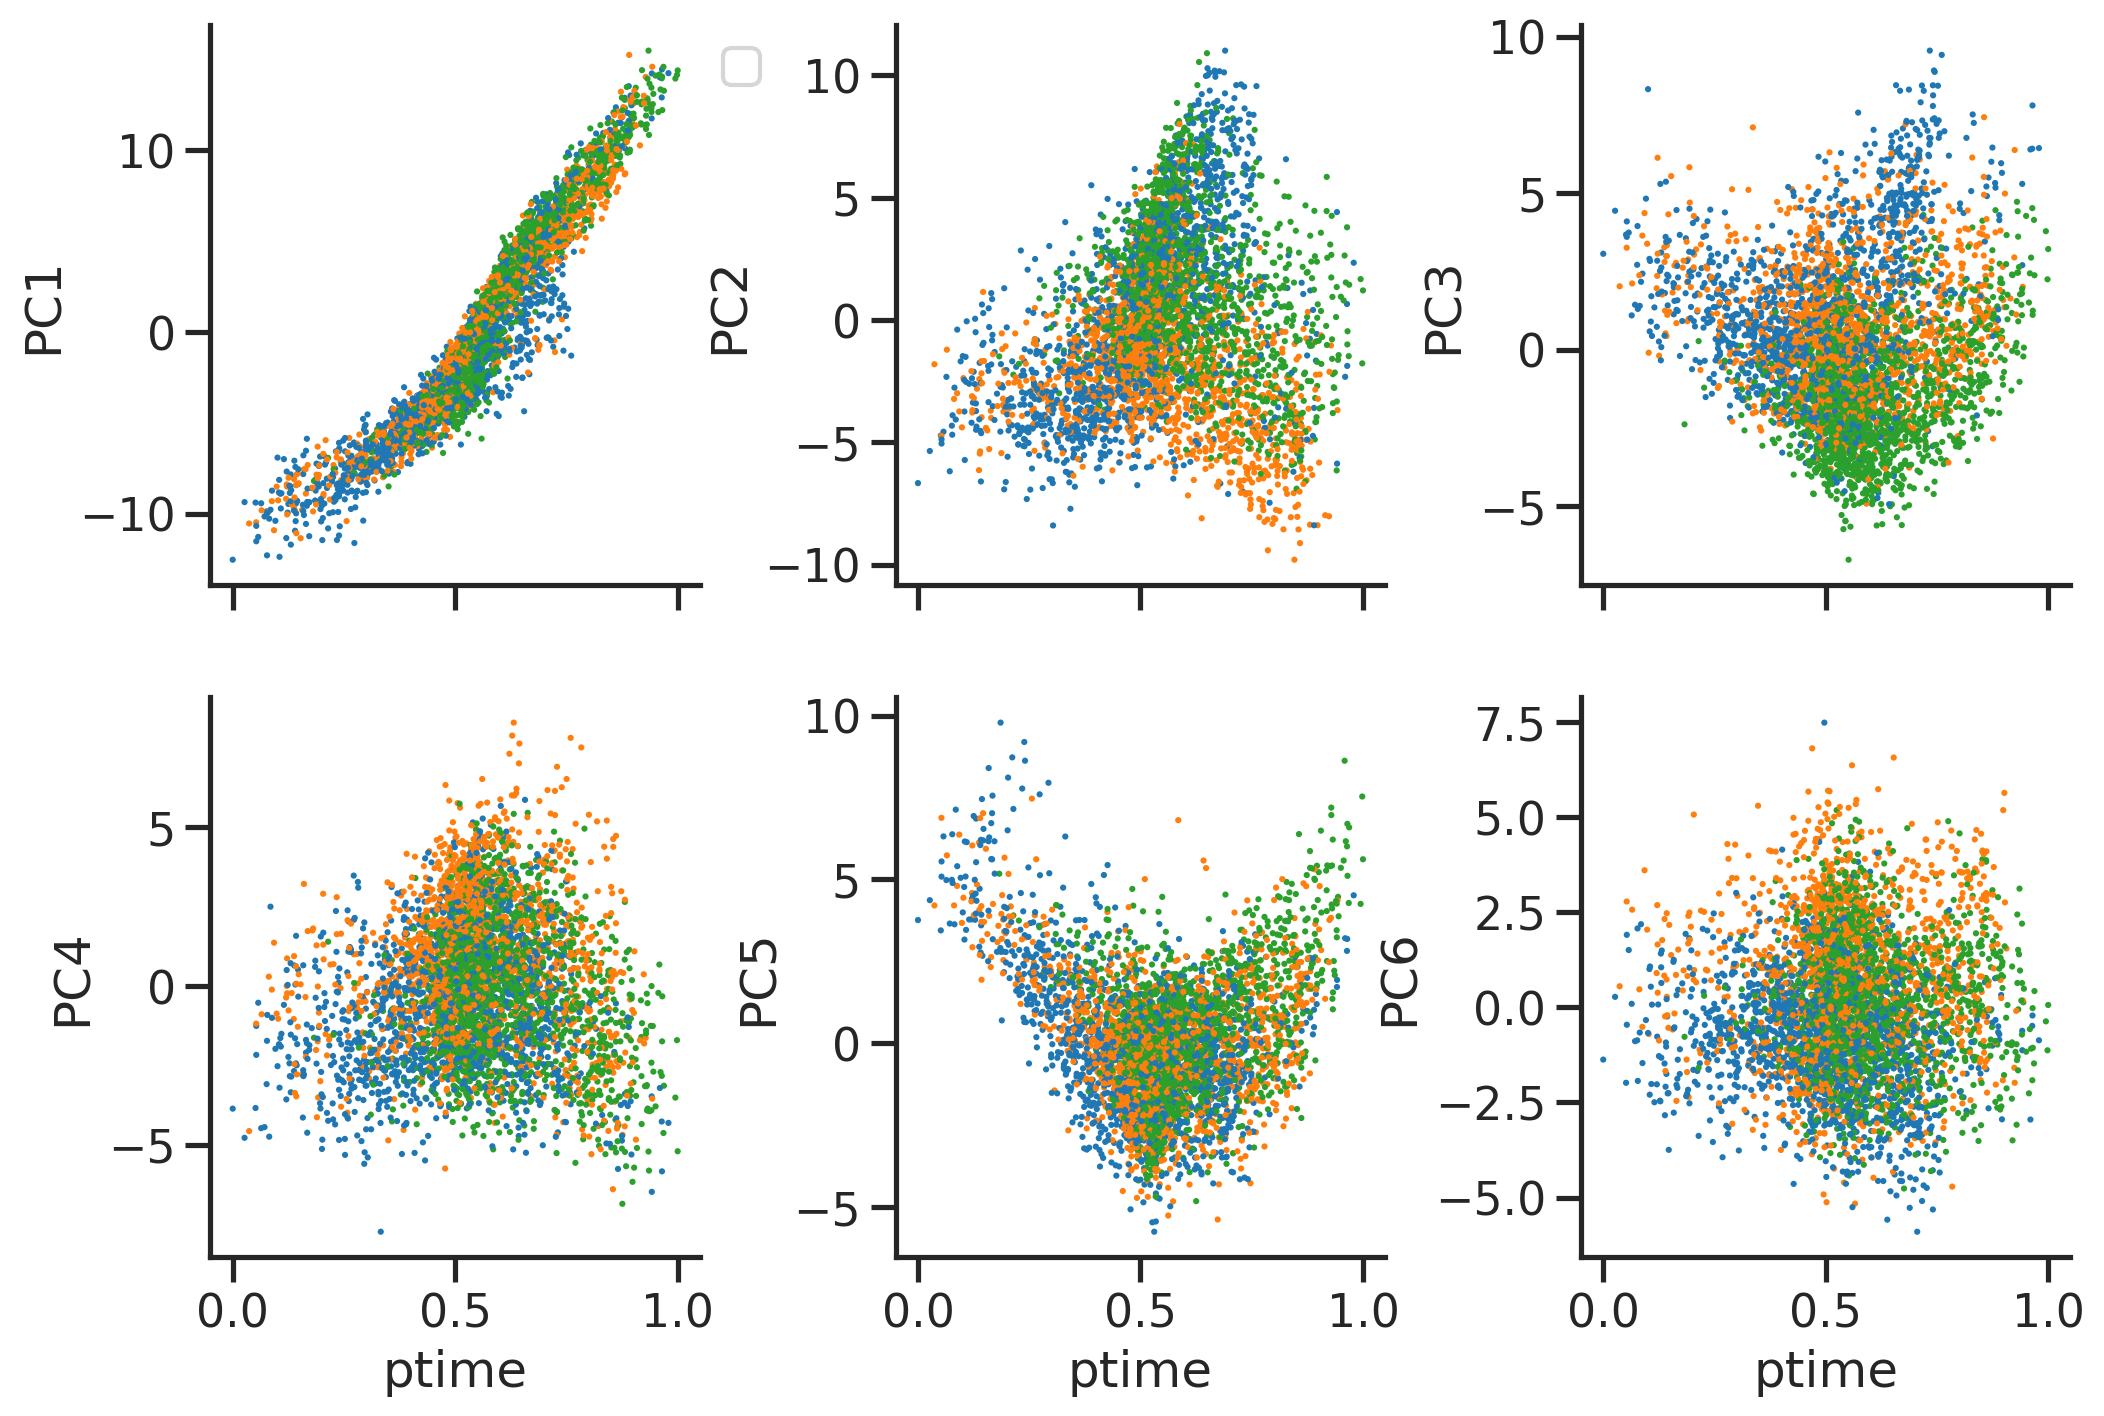

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:06:55 - maxp pruned
03-28 14:06:55 - cmap pruned
03-28 14:06:55 - kern dropped
03-28 14:06:55 - post pruned
03-28 14:06:55 - FFTM dropped
03-28 14:06:55 - GPOS pruned
03-28 14:06:55 - GSUB pruned
03-28 14:06:55 - name pruned
03-28 14:06:55 - glyf pruned
03-28 14:06:55 - Added gid0 to subset
03-28 14:06:55 - Added first four glyphs to subset
03-28 14:06:55 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:06:55 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'P', 'R', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:06:55 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 27, 36, 37, 38, 39, 42, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:06:55 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:06:55 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'P', 'R'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P28DR_v4_2023-03-28.pdf


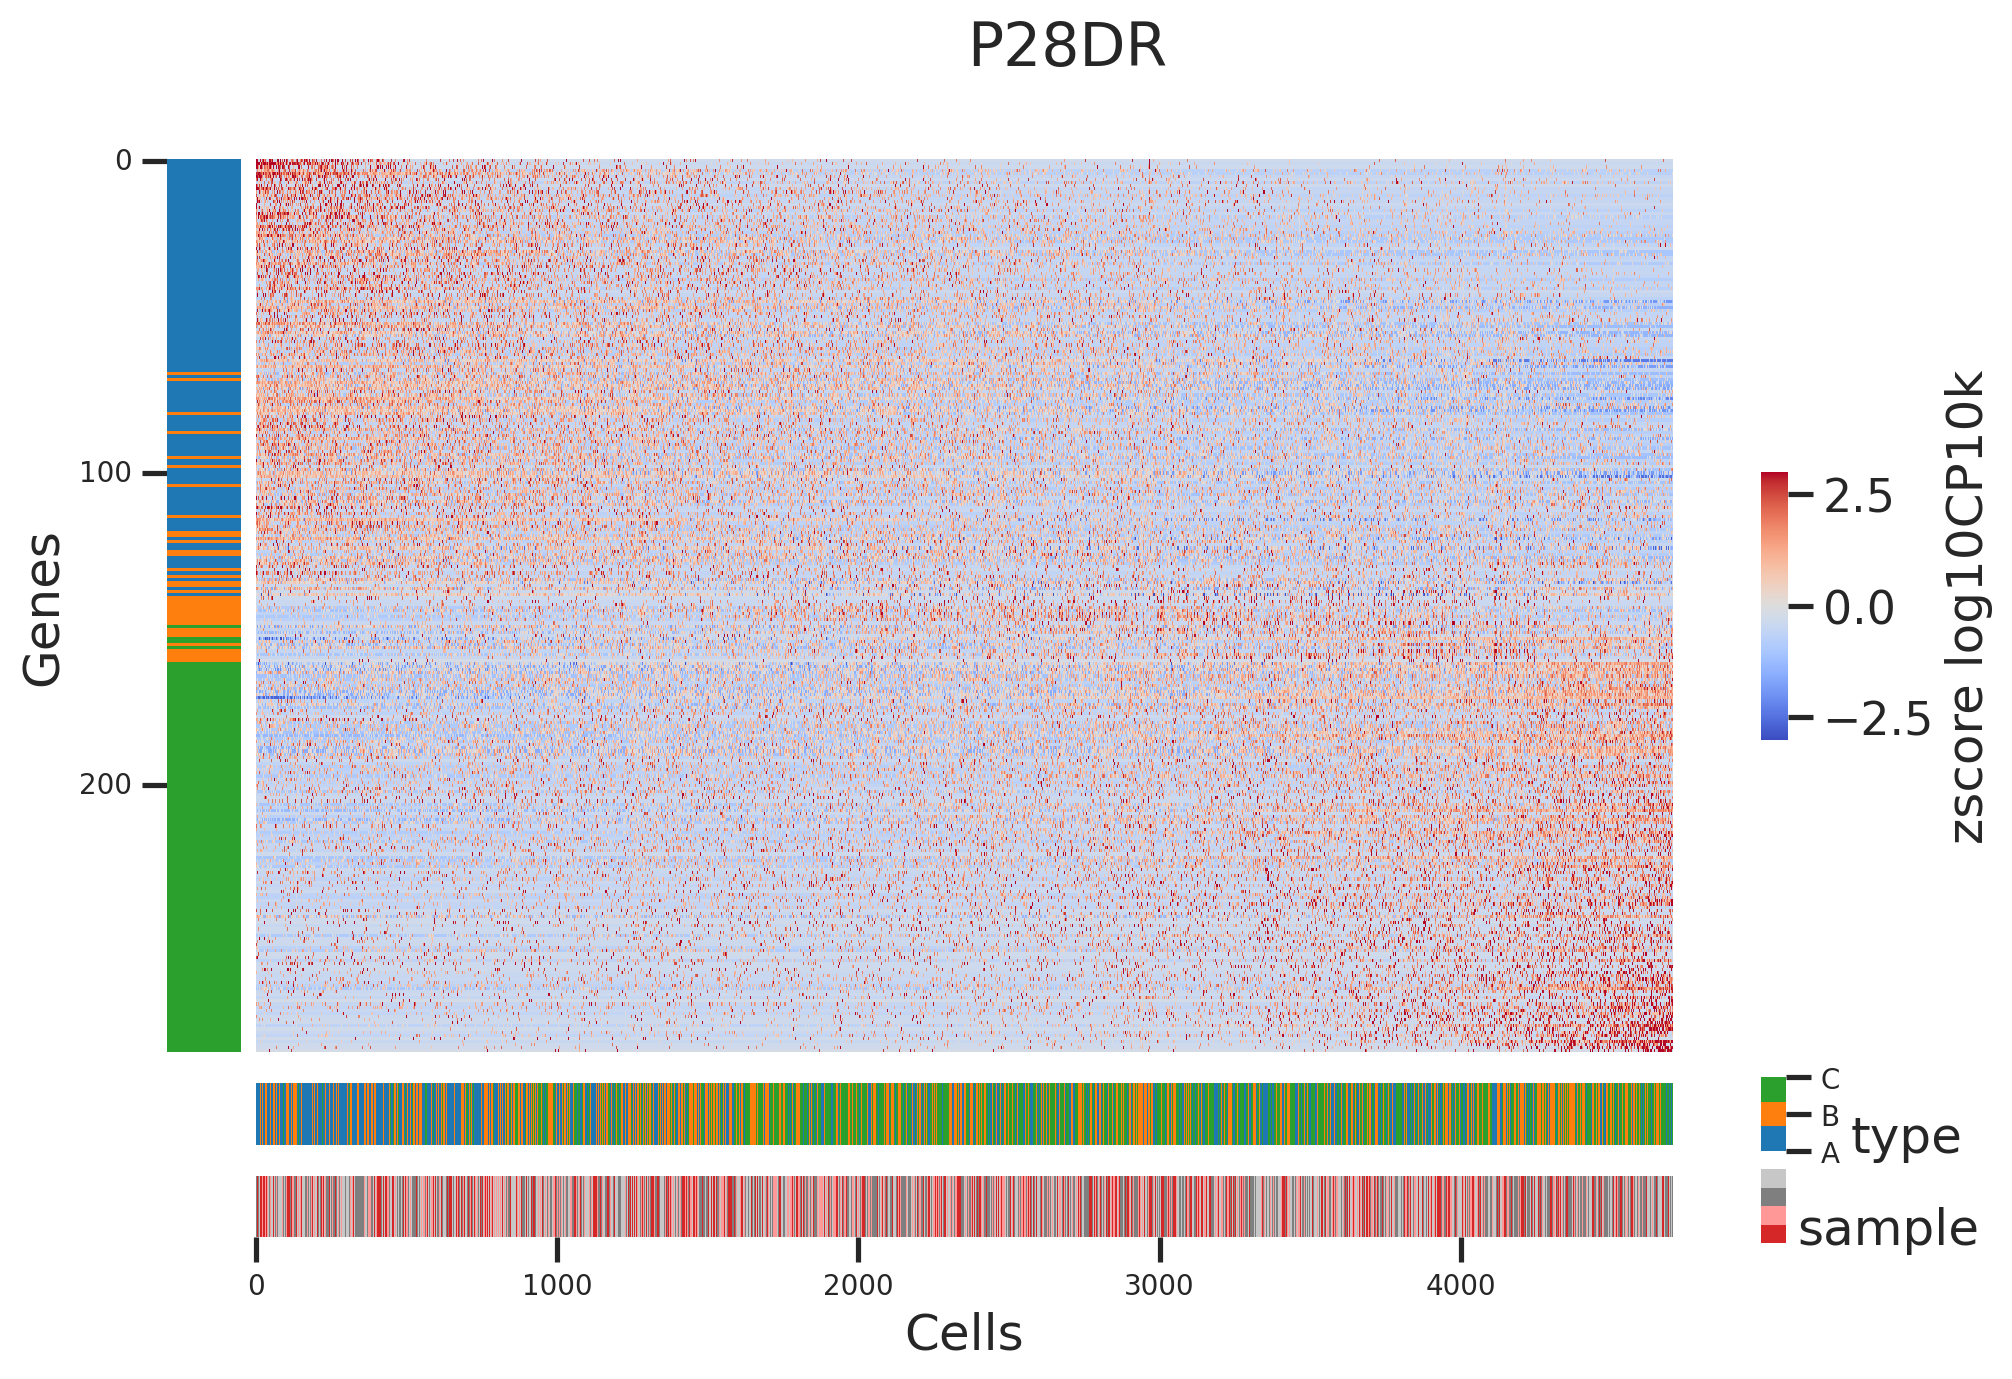

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCAAGTGCACCC-1-P28_dr_1b  -4.956721  5.451199  0.395872  1.491517   
AAACCCACAAGGCCTC-1-P28_dr_3b   6.580738  5.717718  1.916405 -4.290733   
AAACCCATCCCATAAG-1-P28_dr_1a -11.708957 -4.489574  2.627403 -1.530665   
AAACGAAAGAGAGAAC-1-P28_dr_3a  -1.099047  2.752519 -1.670676  1.556473   
AAACGAAAGGTCACCC-1-P28_dr_3b  -3.725854  1.322282 -1.409003 -0.454832   
...                                 ...       ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b  -1.473173 -1.618126 -0.208393  2.848516   
TTTGGTTTCCGAGTGC-1-P28_dr_1a   3.375957  5.598554  2.200201  1.314142   
TTTGTTGCAACGGCCT-1-P28_dr_3b  -5.658245 -2.655397 -1.801636 -2.888268   
TTTGTTGGTTGCACGC-1-P28_dr_3a   2.528752 -5.350506 -0.958425  1.023802   
TTTGTTGTCGGATACT-1-P28_dr_1b   0.826407  2.798141  1.236287  1.692762   

                                   PC5       PC6       PC7       PC8  \
AAACCCAAGTGCACCC-1-P28_dr_1b  2.928320  1.929237 -2.025728  0.186821   
AAACCCACAAGGCCTC-1-P28_dr_3b -1.001441 -0.092016  1.457236 -0.451606   
AAACCCATCCCATAAG-1-P28_dr_1a  5.521658  0.640679 -0.158427 -0.144235   
AAACGAAAGAGAGAAC-1-P28_dr_3a  0.009025 -2.186415  0.934263 -1.651172   
AAACGAAAGGTCACCC-1-P28_dr_3b -2.050268 -0.628885 -3.315818 -3.028511   
...                                ...       ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b -0.619674 -0.049181  1.009222  2.527795   
TTTGGTTTCCGAGTGC-1-P28_dr_1a  0.213265 -0.043893  1.549112  0.629014   
TTTGTTGCAACGGCCT-1-P28_dr_3b  0.114009 -1.240366 -1.107573 -0.640027   
TTTGTTGGTTGCACGC-1-P28_dr_3a  0.309056 -2.319640 -0.428774  0.366193   
TTTGTTGTCGGATACT-1-P28_dr_1b  0.847276  1.794680 -0.835138 -2.048522   

                                   PC9      PC10  ...      PC46      PC47  \
AAACCCAAGTGCACCC-1-P28_dr_1b  3.181376  0.819731  ... -1.038608  0.173135   
AAACCCACAAGGCCTC-1-P28_dr_3b -1.639838  0.499501  ... -0.030105 -0.046341   
AAACCCATCCCATAAG-1-P28_dr_1a -1.802660 -1.194360  ... -0.675875  0.247107   
AAACGAAAGAGAGAAC-1-P28_dr_3a -0.914178  2.145175  ... -0.122494  0.516788   
AAACGAAAGGTCACCC-1-P28_dr_3b -1.274203 -1.363562  ...  0.767802 -0.837807   
...                                ...       ...  ...       ...       ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b -0.127519  0.369372  ... -0.130269  1.124943   
TTTGGTTTCCGAGTGC-1-P28_dr_1a  1.082247 -0.240392  ...  0.498886 -0.327448   
TTTGTTGCAACGGCCT-1-P28_dr_3b  0.839803  0.055865  ... -0.173503 -0.182542   
TTTGTTGGTTGCACGC-1-P28_dr_3a  1.472952 -2.107333  ...  2.577563  1.577907   
TTTGTTGTCGGATACT-1-P28_dr_1b -1.043911 -2.431580  ... -0.582295  0.600019   

                                  PC48      PC49      PC50    type       samp  \
AAACCCAAGTGCACCC-1-P28_dr_1b  0.260843 -1.085504 -2.209563  L2/3_3  P28_dr_1b   
AAACCCACAAGGCCTC-1-P28_dr_3b -1.092848 -0.101324 -1.375942  L2/3_1  P28_dr_3b   
AAACCCATCCCATAAG-1-P28_dr_1a  0.869559  0.704577 -1.003981  L2/3_1  P28_dr_1a   
AAACGAAAGAGAGAAC-1-P28_dr_3a  0.452604  0.110836 -1.523848  L2/3_3  P28_dr_3a   
AAACGAAAGGTCACCC-1-P28_dr_3b -0.296682  1.254967  0.498222  L2/3_3  P28_dr_3b   
...                                ...       ...       ...     ...        ...   
TTTGGTTAGTAACCGG-1-P28_dr_1b -0.780808  0.500357 -0.217531  L2/3_2  P28_dr_1b   
TTTGGTTTCCGAGTGC-1-P28_dr_1a -1.000956 -0.697311  0.059365  L2/3_1  P28_dr_1a   
TTTGTTGCAACGGCCT-1-P28_dr_3b  0.091294 -0.888785 -0.404395  L2/3_2  P28_dr_3b   
TTTGTTGGTTGCACGC-1-P28_dr_3a -0.523139 -0.756001  0.102770  L2/3_2  P28_dr_3a   
TTTGTTGTCGGATACT-1-P28_dr_1b  0.532656 -2.202763 -0.860879  L2/3_2  P28_dr_1b   

                                  umap1     umap2     ptime  
AAACCCAAGTGCACCC-1-P28_dr_1b   9.266105  5.422413  0.515354  
AAACCCACAAGGCCTC-1-P28_dr_3b   5.781382  5.711214  0.748894  
AAACCCATCCCATAAG-1-P28_dr_1a  12.322811  7.374534  0.130622  
AAACGAAAGAGAGAAC-1-P28_dr_3a   7.686917  6.321475  0.539128  
AAACGAAAGGTCACCC-1-P28_dr_3b   9.190690  6.077960  0.498581  
...                     

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)